In [1]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [2]:
# Applying Transforms to the Data
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [3]:
#loading data
dataset = '/userhome/cs2/u3599847/Leture02_Image_Classification_Code/data/flowers'


train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')
test_directory = os.path.join(dataset, 'test')


#Batch size
bs = 32

num_classes = len(os.listdir(valid_directory))
print(num_classes)

#load data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])

}

#size of data to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

#Create iterators for the Data loaded using DataLoader Module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)


train_data_size, valid_data_size, test_data_size

17


(1020, 224, 172)

In [4]:
#Load pretrained model
resnet34 = models.resnet34(pretrained=True)
resnet18 = models.resnet18(pretrained=True)
resnet50 = models.resnet50(pretrained=True)
alexnet = models.alexnet(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
vgg19 = models.vgg19(pretrained=True)

In [5]:
#Freeze model parameters
for param in resnet34.parameters():
    param.requires_grad = False
    
for param in resnet18.parameters():
    param.requires_grad = False
    
for param in resnet50.parameters():
    param.requires_grad = False
    
for param in alexnet.parameters():
    param.requires_grad = False
    
for param in vgg16.parameters():
    param.requires_grad = False
    
for param in vgg19.parameters():
    param.requires_grad = False

In [6]:
# Change the final layer of ResNet34 Model for Transfer Learning
fc_inputs = resnet34.fc.in_features
resnet34.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 17), 
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

# Change the final layer of ResNet18 Model for Transfer Learning
fc_inputs = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 17), 
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 17), 
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

alexnet.classifier[6] = nn.Linear(4096, num_classes)
alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))

vgg16.classifier[6] = nn.Linear(4096, num_classes)
vgg16.classifier.add_module("7", nn.LogSoftmax(dim = 1))

vgg19.classifier[6] = nn.Linear(4096, num_classes)
vgg19.classifier.add_module("7", nn.LogSoftmax(dim = 1))

In [7]:
# Convert model to be used on GPU
resnet34 = resnet34.to('cuda:0')

resnet18 = resnet18.to('cuda:0')

resnet50 = resnet50.to('cuda:0')

alexnet = alexnet.to('cuda:0')

vgg16 = vgg16.to('cuda:0')

vgg19 = vgg19.to('cuda:0')

In [8]:
# Define Optimizer and Loss Function
loss_func_34 = nn.NLLLoss()
optimizer_34 = optim.Adam(resnet34.parameters())

loss_func_18 = nn.NLLLoss()
optimizer_18 = optim.Adam(resnet18.parameters())

loss_func_50 = nn.NLLLoss()
optimizer_50 = optim.Adam(resnet50.parameters())

loss_func_alex = nn.NLLLoss()
optimizer_alex = optim.Adam(alexnet.parameters())

loss_func_vgg16 = nn.NLLLoss()
optimizer_vgg16 = optim.Adam(vgg16.parameters())

loss_func_vgg19 = nn.NLLLoss()
optimizer_vgg19 = optim.Adam(vgg19.parameters())

In [9]:
def train_and_validate(model, loss_criterion, optimizer, epochs):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 10

In [11]:
trained_model_resnet50, history_resnet50 = train_and_validate(resnet50, loss_func_50, optimizer_50, num_epochs)

Epoch: 1/10


KeyboardInterrupt: 

In [ ]:
trained_model_resnet34, history_resnet34 = train_and_validate(resnet34, loss_func_34, optimizer_34, num_epochs)

In [ ]:
trained_model_resnet18, history_resnet18 = train_and_validate(resnet18, loss_func_18, optimizer_18, num_epochs)

In [ ]:
trained_model_alexnet, history_alexnet = train_and_validate(alexnet, loss_func_alex, optimizer_alex, num_epochs)

In [ ]:
trained_model_vgg19, history_vgg19 = train_and_validate(vgg19, loss_func_vgg19, optimizer_vgg19, num_epochs)

In [25]:
#Saving the models:
models = [trained_model_resnet50, trained_model_resnet34, trained_model_resnet18,trained_model_alexnet,trained_model_vgg19]

PATH = '/userhome/cs2/u3599847/Leture02_Image_Classification_Code/saved_models'
#for i in models:
#    torch.save(models[i],PATH)
torch.save(trained_model_resnet50, '/userhome/cs2/u3599847/Leture02_Image_Classification_Code/saved_models/resnet50')
torch.save(trained_model_resnet34, '/userhome/cs2/u3599847/Leture02_Image_Classification_Code/saved_models/resnet34')
torch.save(trained_model_resnet18, '/userhome/cs2/u3599847/Leture02_Image_Classification_Code/saved_models/resnet18')
torch.save(trained_model_alexnet, '/userhome/cs2/u3599847/Leture02_Image_Classification_Code/saved_models/alexnet')
torch.save(trained_model_vgg19, '/userhome/cs2/u3599847/Leture02_Image_Classification_Code/saved_models/vgg19')
#torch.save(history_resnet50, PATH)

In [26]:
#statistics
acc_val_resnet50 = history_resnet50[4][3]
acc_val_restnet34 = history_resnet34[4][3]
#print(history_resnet50)

In [23]:
from scipy.stats import f_oneway
acc_resnet50 = [91.5179, 90.6250, 91.9643]
acc_resnet34 = [93.3036, 93.3036, 94.1964]
acc_resnet18 = [91.0714,90.6250, 92.8571]
acc_alexnet = [87.5000,86.1607, 91.0714]
acc_vgg19 = [80.3571,83.4821, 83.9286]
stat, p = f_oneway(acc_resnet50,acc_resnet34,acc_resnet18,acc_alexnet,acc_vgg19 )
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')


stat=22.371, p=0.000
Probably different distributions


In [36]:
from statsmodels.stats.weightstats import ttest_ind
import numpy as np
import pingouin as pg

# Conducting two-sample ttest
result = pg.ttest(acc_resnet50,
                  acc_vgg19,
                  correction=True)
print(result)

               T       dof alternative     p-val         CI95%  cohen-d  \
T-test  7.374936  2.483933   two-sided  0.009511  [4.5, 13.06]  6.02161   

          BF10     power  
T-test  15.292  0.999454  


In [27]:
def predict(model, test_image_name):
    transform = image_transforms['test']
    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    test_image_tensor = transform(test_image)
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(1, dim=1)
        print("Output class :  ", idx_to_class[topclass.cpu().numpy()[0][0]])
        
idx_to_class = {
    0: "group0",
    1: "group1",
    2: "group2",
    3: "group3",
    4: "group4",
    5: "group5",
    6: "group6",
    7: "group7",
    8: "group8",
    9: "group9",
    10: "group10",
    11: "group11",
    12: "group12",
    13: "group13",
    14: "group14",
    15: "group15",
    16: "group16"

}


Output class :   group1


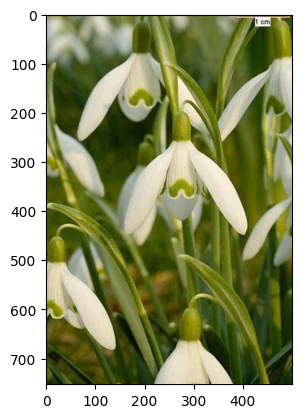

In [30]:
predict(trained_model_alexnet, '/userhome/cs2/u3599847/Leture02_Image_Classification_Code/data/flowers/test/class_1/image_0087.jpg')

In [1]:
# saving history of the models in np array
history_resnet50 = np.array(history_resnet50)
history_resnet34 = np.array(history_resnet34)
history_resnet18 = np.array(history_resnet18)
alexnet = np.array(alexnet)
#vgg16 = np.array(vgg16)
vgg19 = np.array(vgg19)

#print(vgg19.size)

#plotting the models
plt.plot(history_resnet50[:,0:1])
plt.plot(history_resnet34[:,0:1])
plt.plot(history_resnet18[:,0:1])
plt.plot(alexnet[:,0:1])
#plt.plot(vgg16[:,0:1])
plt.plot(vgg19[:,0:1])


plt.legend(['Resnet50', 'Resnet34', 'Resnet18', 'Alexnet', 'Vgg19'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.title('Training Loss vs EPOCH')
plt.savefig(dataset+'loss_curve_v3.png')
plt.show()

NameError: name 'np' is not defined

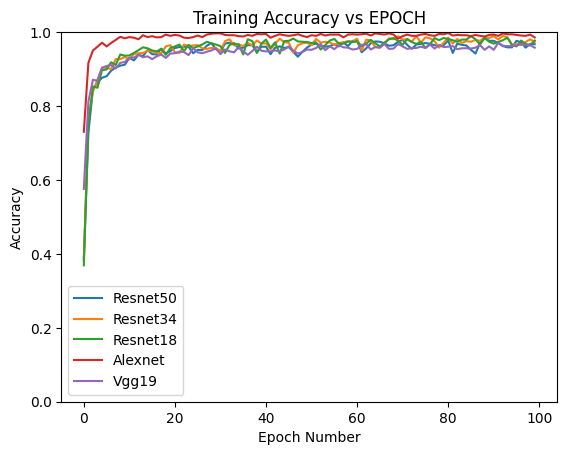

In [24]:
plt.plot(history_resnet50[:,2:3])
plt.plot(history_resnet34[:,2:3])
plt.plot(history_resnet18[:,2:3])
plt.plot(alexnet[:,2:3])
#plt.plot(vgg16[:,2:3])
plt.plot(vgg19[:,2:3])

plt.legend(['Resnet50', 'Resnet34', 'Resnet18', 'Alexnet', 'Vgg19'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)

plt.title('Training Accuracy vs EPOCH')
plt.savefig(dataset+'_accuracy_curve_v2.png')
plt.show()

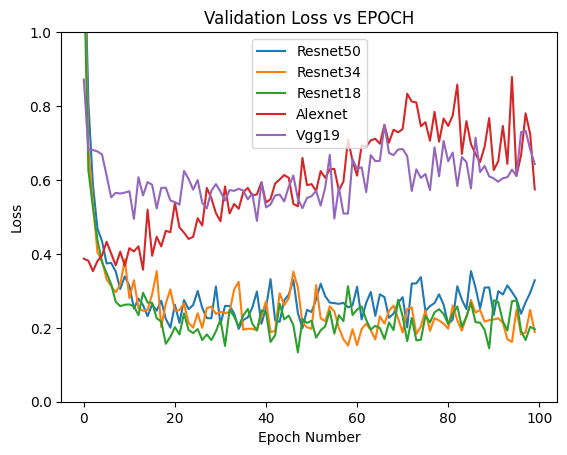

In [23]:
# saving models in np array
history_resnet50 = np.array(history_resnet50)
history_resnet34 = np.array(history_resnet34)
history_resnet18 = np.array(history_resnet18)
alexnet = np.array(alexnet)
#vgg16 = np.array(vgg16)
vgg19 = np.array(vgg19)

#print(vgg19.size)

#plotting the models
plt.plot(history_resnet50[:,1:2])
plt.plot(history_resnet34[:,1:2])
plt.plot(history_resnet18[:,1:2])
plt.plot(alexnet[:,1:2])
#plt.plot(vgg16[:,1:2])
plt.plot(vgg19[:,1:2])


plt.legend(['Resnet50', 'Resnet34', 'Resnet18', 'Alexnet', 'Vgg19'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.title('Validation Loss vs EPOCH')
plt.savefig(dataset+'loss_val_curve_v2.png')
plt.show()

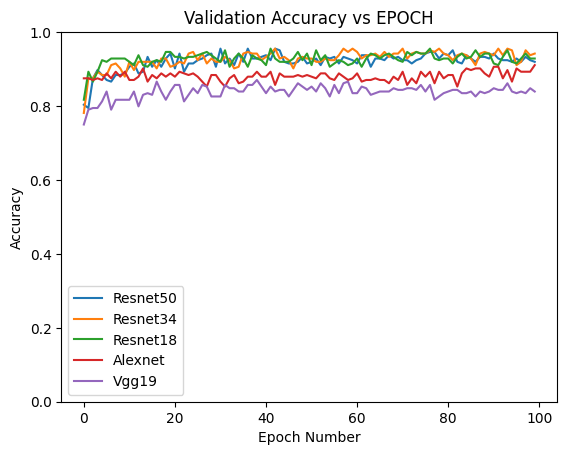

In [20]:
plt.plot(history_resnet50[:,3:4])
plt.plot(history_resnet34[:,3:4])
plt.plot(history_resnet18[:,3:4])
plt.plot(alexnet[:,3:4])
#plt.plot(vgg16[:,3:4])
plt.plot(vgg19[:,3:4])

plt.legend(['Resnet50', 'Resnet34', 'Resnet18', 'Alexnet', 'Vgg19'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)

plt.title('Validation Accuracy vs EPOCH')
plt.savefig(dataset+'validation_accuracy_curve_v2.png')
plt.show()